# NUTS experiments for neutrino NSI problem

In [1]:
import arviz as az

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import optax

import json as js
from tqdm import tqdm

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #select GPU, -1 means use CPU

from jax import config
config.update("jax_enable_x64", True)

In [3]:
from snuddd import config
from snuddd.targets import Nucleus, electron_xe, Electron
from snuddd.models import GeneralNSI
from snuddd.jinterp import interp1d

import numpyro
from numpyro import optim
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro import infer
from numpyro.infer import MCMC, NUTS, autoguide, reparam

import jax.numpy as jnp

2024-05-19 18:36:49.602800: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Preparation for SNuDD 

In [5]:
Xe_nucleus = Nucleus(54, 132, mass=131.9041535 * config.u)

In [6]:
SM_matrix = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 0, 0]])

SM_eta = 0
SM_phi = 0

sm_model = GeneralNSI(SM_matrix, SM_eta, SM_phi)

In [7]:
Xe_nucleus.update_model(sm_model)
Xe_nucleus.prepare_density()

In [8]:
E_Rs = np.logspace(-1, 1, 100) / 1e6 # Recoil Energy in GeV 

sm_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')

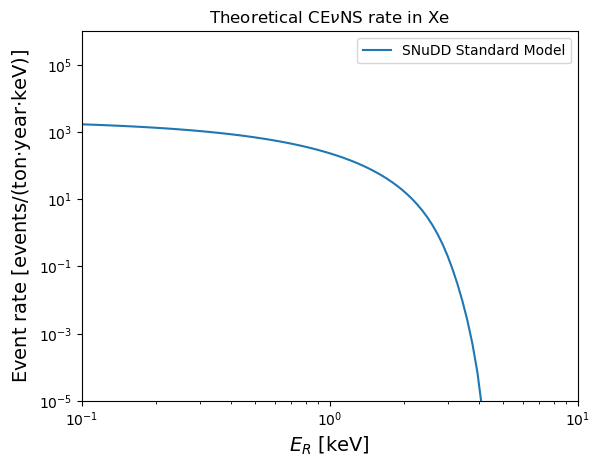

In [9]:
plt.loglog(E_Rs*1e6, abs(sm_spec), label="SNuDD Standard Model") # abs because of the residual imaginary part from the density matrix. All elements have zero imaginary part anyway.
plt.legend()
plt.title(r"Theoretical CE$\nu$NS rate in Xe")
plt.ylabel(r'${\rm d}R/{\rm d}E_R\,\,\left[{\rm ton}^{-1}\,{\rm yr}^{-1}\,{\rm keV}^{-1}\right]$', size=14)
plt.xlabel(r'$E_{R}\,\,\left[{\rm keV}\right]$', size=14)

plt.ylabel(r"Event rate [events/(ton$\cdot$year$\cdot$keV)]")

plt.xlim(xmin=1e-1, xmax=1e1)
plt.ylim(ymax=1e6, ymin=1e-5)

plt.show()

In [10]:
""" IN SI UNIT """
""" Reduced Planck Constant in J·s """
HBAR = 1.054571800E-34
""" Speed of Light in m/s """
C = 2.99792458E8
""" Avogaro's Number in 1/mol """
A_V = 6.022140857E23
""" Charge of Electron in C """
CH_E = 1.6021766208E-19

""" keV in J """
KEV = 1e3 * CH_E
""" GeV in J """
GEV = 1e9 * CH_E

GeV = 1.0
MeV = GeV / 1e3
keV = GeV / 1e6
eV = GeV / 1e9

# GeV ^ -1
m = 1.0 / (HBAR * C / GEV) / GeV
cm = m / 1e2
km = m * 1e3
mm = m / 1e3
um = m / 1e6
nm = m / 1e9
pm = m / 1e12
fm = m / 1e15

# GeV
kg = 1.0 * C**2 / GEV * GeV
ton = kg * 1e3
g = kg * 1e-3

# GeV ^ -1
sec = 1.0 * C * m
dy = 24.0 * 3600.0 * sec
yr = 365.0 * dy

# Fermi's const
Gf = 1.1663787e-5 / GeV**2

# Neutron mass
mn = 0.9314940954 * GeV

# Mixing angle
sin2the = 0.2223

In [11]:
NSI_matrix = np.array([[0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0]])

NSI_eta = 0
NSI_phi = 0

NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)

Xe_nucleus.update_model(NSI_model)
Xe_nucleus.prepare_density()

NSI_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')
acc_data = pd.read_csv('acceptance.csv').drop(columns='Unnamed: 0')

accept = np.array(acc_data['acceptance'])
energy = np.array(acc_data['energy'] * keV)
accept = interp1d(energy, accept)

In [12]:
Xe_electron = Electron(Xe_nucleus, None, None)
Xe_electron.update_model(NSI_model)
Xe_electron.prepare_density()

In [14]:
er = energy
tot_rate = (np.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er).astype("float64") * (yr**(-1) * keV**(-1) * ton**(-1)))

delta_energy = er[1] - er[0]
total_rate = np.sum(tot_rate) * delta_energy
upper_lim_B8_flux = 5.25e6 * 2.3 * cm**-2 * sec**-1
lower_lim_B8_flux = 5.25e6 * 0.9 * cm**-2 * sec**-1
tot_flux = 5.46e6 * cm**-2 * sec**-1
upper_lim_total_rate = total_rate / tot_flux * upper_lim_B8_flux
lower_lim_total_rate = total_rate / tot_flux * lower_lim_B8_flux
print("{:} {:.2f} per ty".format("90% UL B8 solar neutrino rate:", upper_lim_total_rate / (yr**(-1) * ton**(-1))))

90% UL B8 solar neutrino rate: 13.12 per ty


In [ ]:
pp_sum = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))

## Define the model

In [21]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer
from numpyro import handlers


# @handlers.reparam(config={"phi": infer.reparam.CircularReparam()})
def nsi_rate(rate = None):
    eps_ee = numpyro.sample("eps_ee", dist.Uniform(-5.0, 5.0))
    eps_em = numpyro.sample("eps_em", dist.Uniform(-5.0, 5.0))
    eps_et = numpyro.sample("eps_et", dist.Uniform(-5.0, 5.0))
    eps_mm = numpyro.sample("eps_mm", dist.Uniform(-5.0, 5.0))
    eps_mt = numpyro.sample("eps_mt", dist.Uniform(-5.0, 5.0))
    eps_tt = numpyro.sample("eps_tt", dist.Uniform(-5.0, 5.0))
    sineta = numpyro.sample("sineta", dist.Uniform(-1., 1.))
    phi = numpyro.sample("phi", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    
    NSI_matrix = jnp.asarray([[eps_ee, eps_em, eps_et],
                       [eps_em, eps_mm, eps_mt],
                       [eps_et, eps_mt, eps_tt]])
    NSI_eta = jnp.arcsin(sineta)
    NSI_phi = phi

    NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)
    Xe_nucleus.update_model(NSI_model)
    Xe_nucleus.prepare_density()

    tot_rate = jnp.sum(jnp.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er) * (yr**(-1) * keV**(-1) * ton**(-1))) * delta_energy
    tot_lambda = tot_rate * 0.6 * ton * yr + 5.38
    
    # Xe_electron = Electron(Xe_nucleus, None, None)
    Xe_electron.update_model(NSI_model)
    Xe_electron.prepare_density()
    pp_sum_NSI = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))
    # pp_10kev_NSI = jnp.real(Xe_electron.spectrum(np.array([1.0e-5]), nu = 'pp'))
    
    measured_pp_ratio = numpyro.sample("measured_pp_ratio", dist.TruncatedNormal(1.72, 1.72, low=0.0), obs=pp_sum_NSI/pp_sum)
    
    
    numpyro.sample("rate", dist.Poisson(tot_lambda), obs=rate)

    
    # numpyro.factor('rate_lh',jax.scipy.stats.poisson.logpmf(rate, tot_lambda))

    

## Run samplers

In [27]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.98, step_size=0.06, adapt_step_size=False),
    num_warmup=2000,
    num_samples=5000,
    num_chains=4,
    progress_bar=True,
    chain_method='sequential'
)

time1 = time.time()
%time sampler.run(jax.random.PRNGKey(11), rate = 6, extra_fields = ['num_steps', 'accept_prob'])
time2 = time.time()
sampler.print_summary()

sample: 100%|████████████████████████████████████████████| 7000/7000 [2:15:45<00:00,  1.16s/it, 63 steps of size 6.00e-02. acc. prob=0.98]


CPU times: user 7h 28min 2s, sys: 2h 40min 59s, total: 10h 9min 1s
Wall time: 10h 6min 35s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee      0.06      2.69      0.07     -4.32      4.32  11005.85      1.00
    eps_em     -0.02      2.46     -0.01     -3.93      4.31  14296.77      1.00
    eps_et      0.02      2.40      0.02     -3.93      4.14  12701.39      1.00
    eps_mm      0.02      2.75      0.03     -4.23      4.52  15635.22      1.00
    eps_mt      0.02      2.66      0.06     -4.34      4.23  12516.71      1.00
    eps_tt     -0.02      2.75     -0.00     -4.57      4.23  12687.41      1.00
       phi     -0.00      0.10      0.00     -0.14      0.14   4690.40      1.00
    sineta     -0.57      0.04     -0.57     -0.63     -0.51   3074.12      1.00

Number of divergences: 10


In [28]:
arviz_obj = az.from_numpyro(sampler)
# az.to_json(arviz_obj, "nrer_az/plain_step_fixed_size_0.98_5k_4.json")

'nrer_az/plain_step_fixed_size_0.98_5k_4.json'

In [29]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.98, step_size=0.06, adapt_step_size=False),
    num_warmup=2000,
    num_samples=5000,
    num_chains=6,
    progress_bar=True,
    chain_method='sequential'
)

time1 = time.time()
%time sampler.run(jax.random.PRNGKey(11), rate = 6, extra_fields = ['num_steps', 'accept_prob'])
time2 = time.time()
sampler.print_summary()

sample: 100%|████████████████████████████████████████████| 7000/7000 [2:59:25<00:00,  1.54s/it, 63 steps of size 6.00e-02. acc. prob=0.99]


CPU times: user 12h 17min 16s, sys: 4h 28min 22s, total: 16h 45min 38s
Wall time: 16h 39min 34s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee      0.02      2.67      0.04     -4.14      4.51  16171.02      1.00
    eps_em     -0.04      2.45     -0.04     -4.26      3.97  20274.39      1.00
    eps_et      0.03      2.41      0.03     -4.06      4.07  20152.91      1.00
    eps_mm      0.03      2.77      0.04     -4.29      4.51  22517.11      1.00
    eps_mt      0.03      2.67      0.02     -4.23      4.41  19077.30      1.00
    eps_tt     -0.05      2.72     -0.07     -4.29      4.41  19756.33      1.00
       phi      0.00      0.10      0.00     -0.14      0.15   8561.14      1.00
    sineta     -0.57      0.04     -0.57     -0.63     -0.52   7224.22      1.00

Number of divergences: 4


In [30]:
arviz_obj = az.from_numpyro(sampler)
# az.to_json(arviz_obj, "nrer_az/plain_step_fixed_size_0.98_5k_6.json")

'nrer_az/plain_step_fixed_size_0.98_5k_6.json'

In [32]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.98, step_size=0.06, adapt_step_size=False),
    num_warmup=2000,
    num_samples=5000,
    num_chains=4,
    progress_bar=True,
    chain_method='sequential'
)

time1 = time.time()
%time sampler.run(jax.random.PRNGKey(10), rate = 6, extra_fields = ['num_steps', 'accept_prob'])
time2 = time.time()
sampler.print_summary()

sample: 100%|████████████████████████████████████████████| 7000/7000 [2:04:14<00:00,  1.06s/it, 63 steps of size 6.00e-02. acc. prob=0.99]

CPU times: user 6h 28min 33s, sys: 2h 17min 52s, total: 8h 46min 25s
Wall time: 8h 45min 15s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee      0.03      2.64     -0.00     -4.12      4.46  11872.91      1.00
    eps_em     -0.05      2.45     -0.06     -4.33      3.86  13718.94      1.00
    eps_et     -0.02      2.43     -0.04     -4.05      4.14  13942.64      1.00
    eps_mm      0.03      2.76      0.06     -4.21      4.57  15032.29      1.00
    eps_mt     -0.00      2.68     -0.01     -4.47      4.18  13123.19      1.00
    eps_tt     -0.05      2.76     -0.09     -4.71      4.07  13575.80      1.00
       phi      0.00      0.10      0.00     -0.15      0.14   3235.14      1.00
    sineta     -0.57      0.04     -0.57     -0.62     -0.52   5097.28      1.00

Number of divergences: 13


In [33]:
arviz_obj = az.from_numpyro(sampler)
# az.to_json(arviz_obj, "nrer_az/plain_step_fixed_size_0.98_5k_4_1.json")

'nrer_az/plain_step_fixed_size_0.98_5k_4_1.json'

In [34]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.98, step_size=0.06, adapt_step_size=False),
    num_warmup=2000,
    num_samples=5000,
    num_chains=6,
    progress_bar=True,
    chain_method='sequential'
)

time1 = time.time()
%time sampler.run(jax.random.PRNGKey(9), rate = 6, extra_fields = ['num_steps', 'accept_prob'])
time2 = time.time()
sampler.print_summary()

sample: 100%|████████████████████████████████████████████| 7000/7000 [2:07:07<00:00,  1.09s/it, 63 steps of size 6.00e-02. acc. prob=0.99]

CPU times: user 9h 59min 12s, sys: 3h 30min 2s, total: 13h 29min 14s
Wall time: 13h 27min 30s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee     -0.02      2.66      0.02     -4.68      3.97  17042.27      1.00
    eps_em     -0.03      2.46     -0.04     -4.15      4.09  21011.05      1.00
    eps_et      0.02      2.44      0.01     -3.85      4.35  19984.46      1.00
    eps_mm      0.02      2.75      0.03     -4.26      4.51  24833.45      1.00
    eps_mt     -0.01      2.67     -0.02     -4.49      4.18  20305.25      1.00
    eps_tt     -0.05      2.71     -0.09     -4.47      4.23  22079.37      1.00
       phi      0.00      0.10      0.00     -0.15      0.14   6748.51      1.00
    sineta     -0.57      0.04     -0.57     -0.63     -0.51   5734.20      1.00

Number of divergences: 7


In [35]:
arviz_obj = az.from_numpyro(sampler)
# az.to_json(arviz_obj, "nrer_az/plain_step_fixed_size_0.98_5k_6_1.json")

'nrer_az/plain_step_fixed_size_0.98_5k_6_1.json'

In [36]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.98, step_size=0.06, adapt_step_size=False),
    num_warmup=2000,
    num_samples=5000,
    num_chains=6,
    progress_bar=True,
    chain_method='sequential'
)

time1 = time.time()
%time sampler.run(jax.random.PRNGKey(8), rate = 6, extra_fields = ['num_steps', 'accept_prob'])
time2 = time.time()
sampler.print_summary()

sample: 100%|████████████████████████████████████████████| 7000/7000 [2:11:48<00:00,  1.13s/it, 31 steps of size 6.00e-02. acc. prob=0.99]


CPU times: user 10h 28min 19s, sys: 3h 20min 50s, total: 13h 49min 9s
Wall time: 13h 47min 42s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee      0.03      2.67      0.02     -4.36      4.26  17304.76      1.00
    eps_em     -0.00      2.45     -0.02     -4.13      4.07  21887.66      1.00
    eps_et      0.01      2.42      0.02     -4.12      4.00  19493.99      1.00
    eps_mm     -0.00      2.78      0.02     -4.53      4.30  22535.82      1.00
    eps_mt      0.04      2.71      0.05     -4.40      4.32  18721.92      1.00
    eps_tt     -0.05      2.73     -0.07     -4.41      4.31  20707.98      1.00
       phi      0.00      0.09      0.00     -0.15      0.14   9002.24      1.00
    sineta     -0.57      0.04     -0.57     -0.63     -0.52   9446.46      1.00

Number of divergences: 3


In [37]:
arviz_obj = az.from_numpyro(sampler)
az.to_json(arviz_obj, "nrer_az/plain_step_fixed_size_0.98_5k_6_2.json")

'nrer_az/plain_step_fixed_size_0.98_5k_6_2.json'